### Import Libraries

In [1]:
import cv2
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report


### Import DATA

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arjunbasandrai/25-indian-bird-species-with-226k-images")

print("Path to dataset files:", path)

100%|██████████| 9.33G/9.33G [07:20<00:00, 22.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/arjunbasandrai/25-indian-bird-species-with-226k-images/versions/4


### Data Preprocessing & EDA

In [4]:
os.listdir("/root/.cache/kagglehub/datasets/arjunbasandrai/25-indian-bird-species-with-226k-images/versions/4/training_set/training_set/")

['Asian Green Bee-Eater',
 'Gray Wagtail',
 'Indian Roller',
 'Brown-Headed Barbet',
 'Coppersmith Barbet',
 'Ruddy Shelduck',
 'Common Tailorbird',
 'Sarus Crane',
 'White-Breasted Waterhen',
 'Cattle Egret',
 'White Wagtail',
 'Hoopoe',
 'Indian Pitta',
 'House Crow',
 'Rufous Treepie',
 'Common Kingfisher',
 'Indian Peacock',
 'Jungle Babbler',
 'Common Rosefinch',
 'White-Breasted Kingfisher',
 'Indian Grey Hornbill',
 'Red-Wattled Lapwing',
 'Northern Lapwing',
 'Common Myna',
 'Forest Wagtail']

In [5]:
labels = ['Asian Green Bee-Eater',
 'Gray Wagtail',
 'Indian Roller',
 'Brown-Headed Barbet',
 'Coppersmith Barbet',
 'Ruddy Shelduck',
 'Common Tailorbird',
 'Sarus Crane',
 'White-Breasted Waterhen',
 'Cattle Egret',
 'White Wagtail',
 'Hoopoe',
 'Indian Pitta',
 'House Crow',
 'Rufous Treepie',
 'Common Kingfisher',
 'Indian Peacock',
 'Jungle Babbler',
 'Common Rosefinch',
 'White-Breasted Kingfisher',
 'Indian Grey Hornbill',
 'Red-Wattled Lapwing',
 'Northern Lapwing',
 'Common Myna',
 'Forest Wagtail']

In [6]:
img_path = "/root/.cache/kagglehub/datasets/arjunbasandrai/25-indian-bird-species-with-226k-images/versions/4/training_set/training_set/"

In [7]:
img_list=[]
label_list=[]

for label in labels:
    for img_file in os.listdir(img_path+label):
        img_list.append(img_path+label+'/'+img_file)
        label_list.append(label)

In [8]:
df = pd.DataFrame({"img":img_list,"label":label_list})

In [9]:
df.head()

img                  label
0  /root/.cache/kagglehub/datasets/arjunbasandrai...  Asian Green Bee-Eater
1  /root/.cache/kagglehub/datasets/arjunbasandrai...  Asian Green Bee-Eater
2  /root/.cache/kagglehub/datasets/arjunbasandrai...  Asian Green Bee-Eater
3  /root/.cache/kagglehub/datasets/arjunbasandrai...  Asian Green Bee-Eater
4  /root/.cache/kagglehub/datasets/arjunbasandrai...  Asian Green Bee-Eater

In [10]:
df.sample(5)

img  \
17856  /root/.cache/kagglehub/datasets/arjunbasandrai...   
15591  /root/.cache/kagglehub/datasets/arjunbasandrai...   
19345  /root/.cache/kagglehub/datasets/arjunbasandrai...   
21385  /root/.cache/kagglehub/datasets/arjunbasandrai...   
472    /root/.cache/kagglehub/datasets/arjunbasandrai...   

                           label  
17856  White-Breasted Kingfisher  
15591             Jungle Babbler  
19345        Red-Wattled Lapwing  
21385                Common Myna  
472        Asian Green Bee-Eater

In [11]:
df.shape

(22620, 2)

In [12]:
df.value_counts("label")

label
Jungle Babbler               930
White-Breasted Kingfisher    930
Red-Wattled Lapwing          930
Northern Lapwing             930
Sarus Crane                  930
White Wagtail                930
White-Breasted Waterhen      930
Gray Wagtail                 926
Common Myna                  926
Indian Roller                926
Ruddy Shelduck               925
Hoopoe                       924
House Crow                   924
Forest Wagtail               924
Common Kingfisher            924
Brown-Headed Barbet          924
Asian Green Bee-Eater        924
Indian Grey Hornbill         922
Indian Peacock               919
Common Rosefinch             919
Cattle Egret                 918
Common Tailorbird            918
Rufous Treepie               860
Coppersmith Barbet           778
Indian Pitta                 629
Name: count, dtype: int64

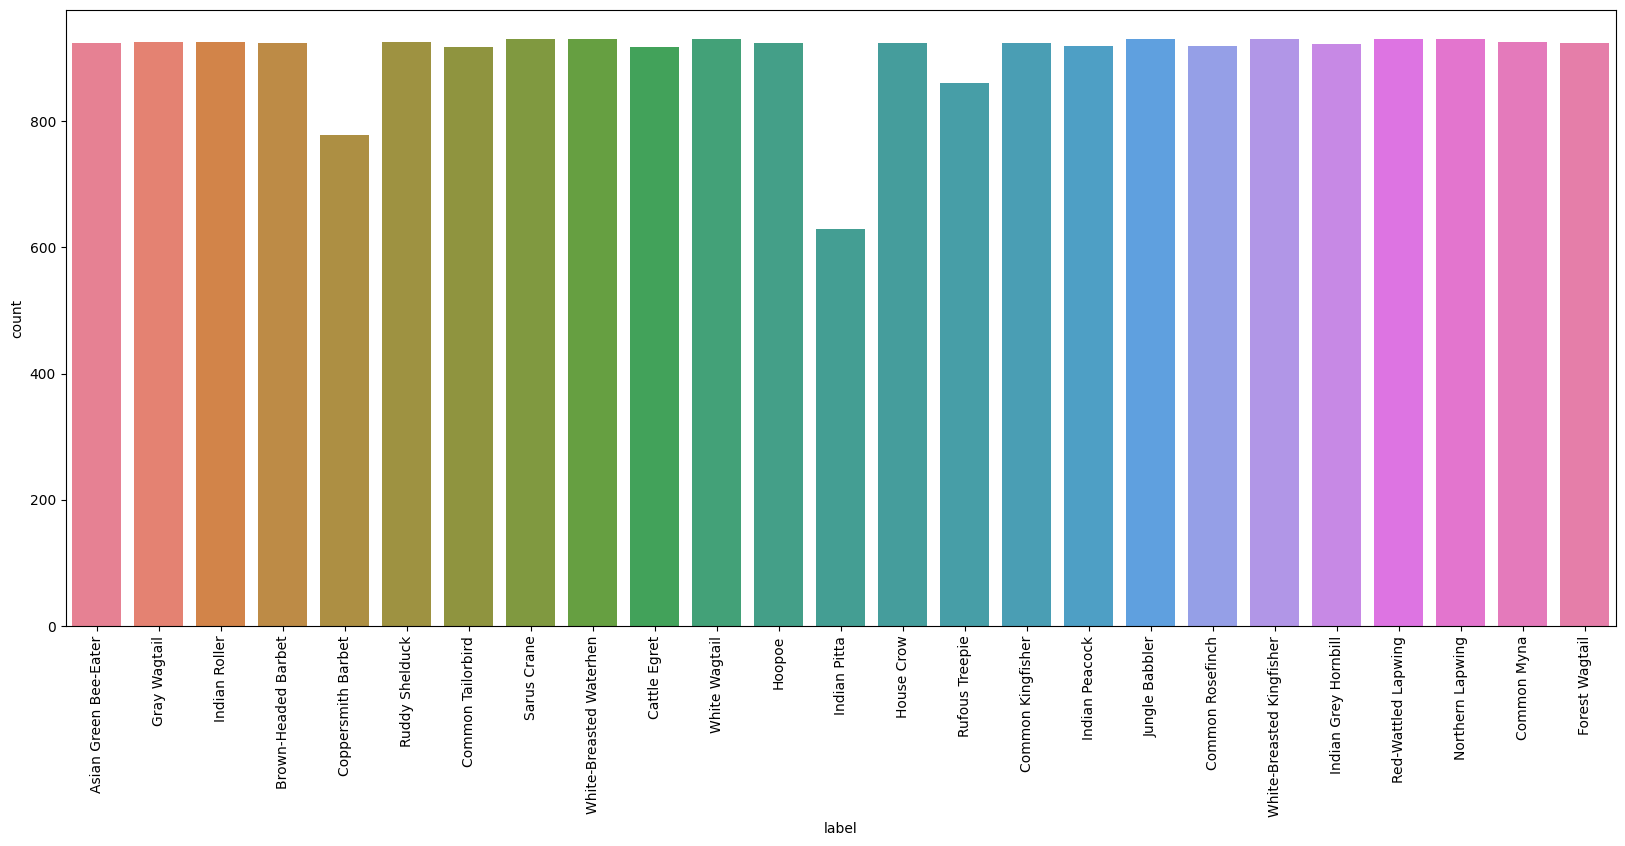

In [13]:
plt.figure(figsize=(20,8))
sns.countplot(data=df, x='label', hue="label")
plt.xticks(rotation=90);

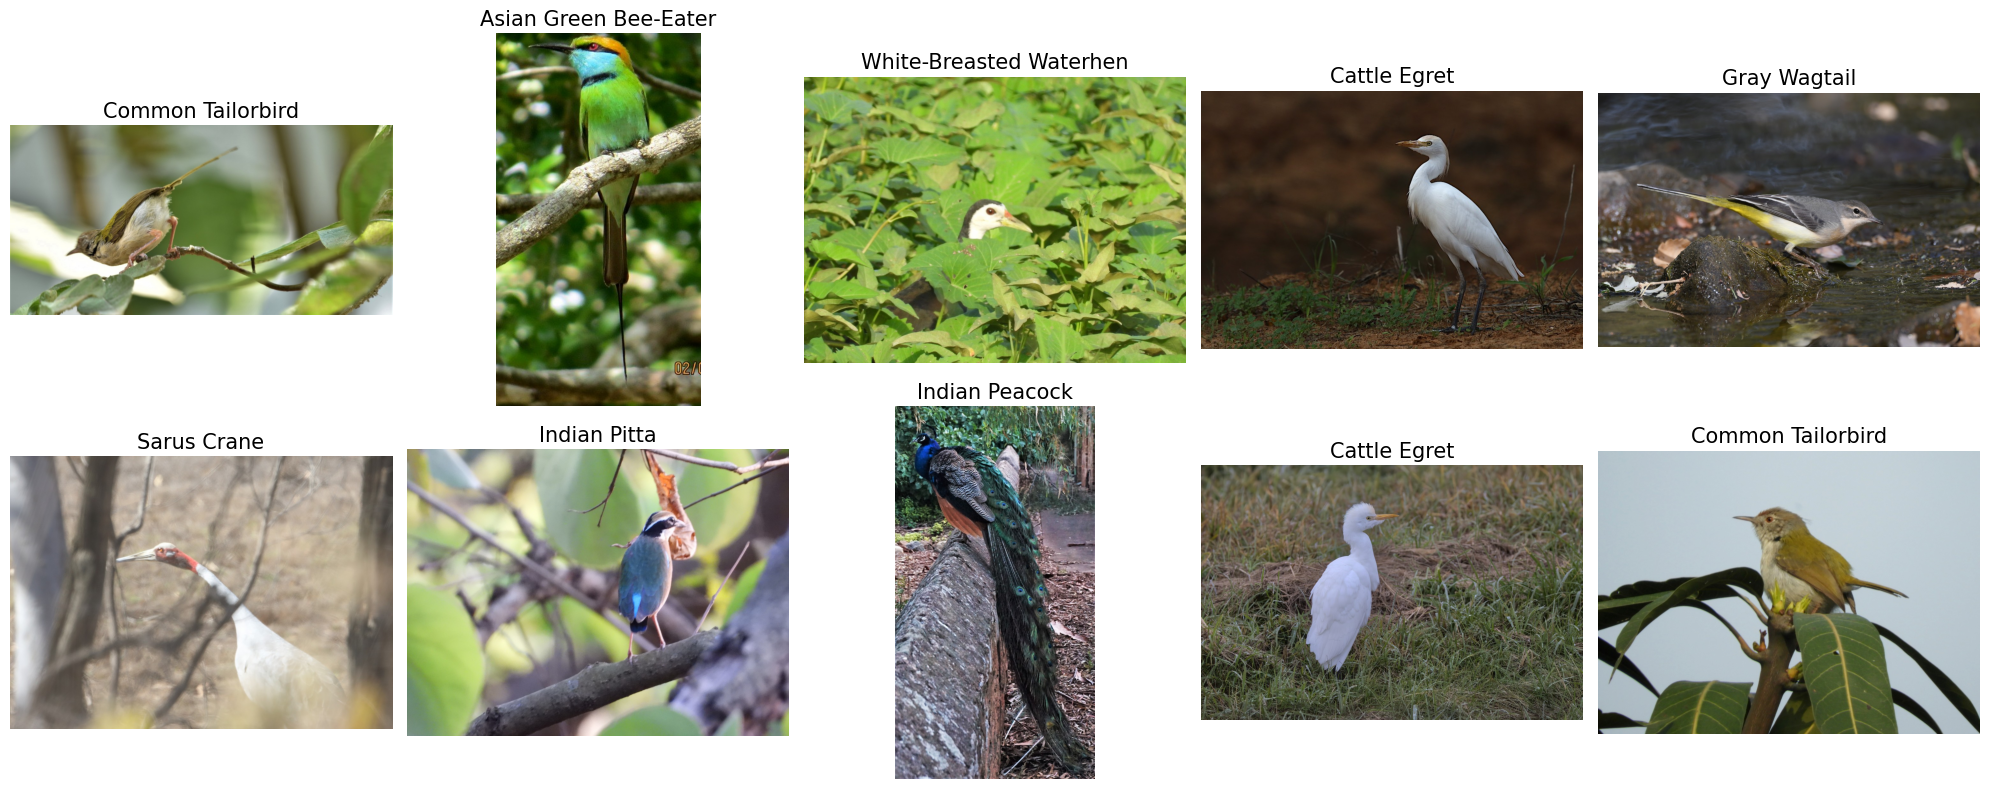

In [15]:
def show_images(df, num=10):
    sample_df = df.sample(num)
    images_per_row = 5
    num_rows = (num - 1) // images_per_row + 1

    plt.figure(figsize=(images_per_row * 4, num_rows * 4))

    for i, (idx, row) in enumerate(sample_df.iterrows()):
        img = cv2.imread(row['img'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(img)
        plt.title(row['label'], fontsize=15)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_images(df, num=10)

### Modelling

In [16]:
data_dir = "/root/.cache/kagglehub/datasets/arjunbasandrai/25-indian-bird-species-with-226k-images/versions/4/training_set/training_set/"

img_width, img_height = 224, 224
batch_size = 256

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.15,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.15,
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed = 42
)

test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=42
)

num_classes = train_generator.num_classes

Found 19242 images belonging to 25 classes.
Found 3378 images belonging to 25 classes.


In [17]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

model = Sequential()
model.add(base_model)

for layer in base_model.layers:
    layer.trainable = False

model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [18]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("indianBirds_InceptionV3Model.keras", save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3, min_lr=1e-5)
]

history = model.fit(train_generator, validation_data=test_generator, epochs=20, callbacks=callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 535s 7s/step - accuracy: 0.4839 - loss: 1.9226 - val_accuracy: 0.7741 - val_loss: 0.7693 - learning_rate: 0.0010
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 487s 6s/step - accuracy: 0.7722 - loss: 0.7665 - val_accuracy: 0.8085 - val_loss: 0.6593 - learning_rate: 0.0010
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 493s 6s/step - accuracy: 0.8019 - loss: 0.6460 - val_accuracy: 0.8227 - val_loss: 0.6083 - learning_rate: 0.0010
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 490s 6s/step - accuracy: 0.8210 - loss: 0.5883 - val_accuracy: 0.8301 - val_loss: 0.5739 - learning_rate: 0.0010
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 491s 6s/step - accuracy: 0.8349 - loss: 0.5391 - val_accuracy: 0.8333 - val_loss: 0.5693 - learning_rate: 0.0010
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 493s 6s/step - accuracy: 0.8511 - loss: 0.4925 - val_accuracy: 0.8265 - val_loss: 0.5934 - learning_rate: 0.0010
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 490s 6s/step - accuracy: 0.8541 - loss: 0.4676 - val_acc

In [19]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.8637 - loss: 0.5097
Test Loss: 0.4997
Test Accuracy: 0.8603


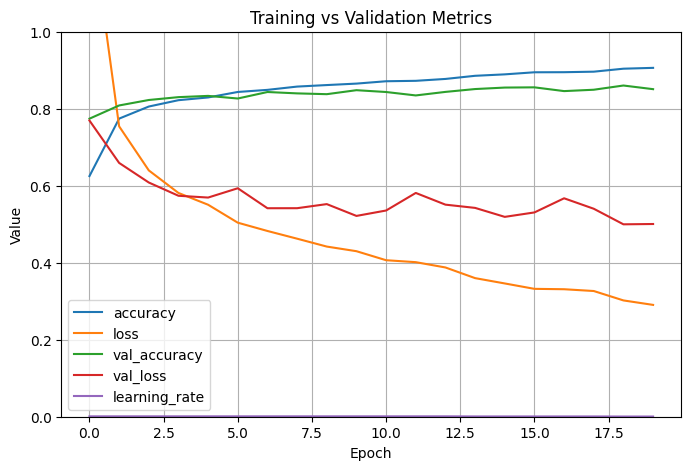

In [27]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title("Training vs Validation Metrics")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.show()

In [24]:
x_test, y_test = next(test_generator)
for i in range(1, len(test_generator)):
    x, y = next(test_generator)
    x_test = np.append(x_test, x, axis=0)
    y_test = np.append(y_test, y, axis=0)

# Değerlendirme
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"Test loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8626 - loss: 0.4727
Test loss: 0.4997
Test Accuracy: 0.8603


106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step


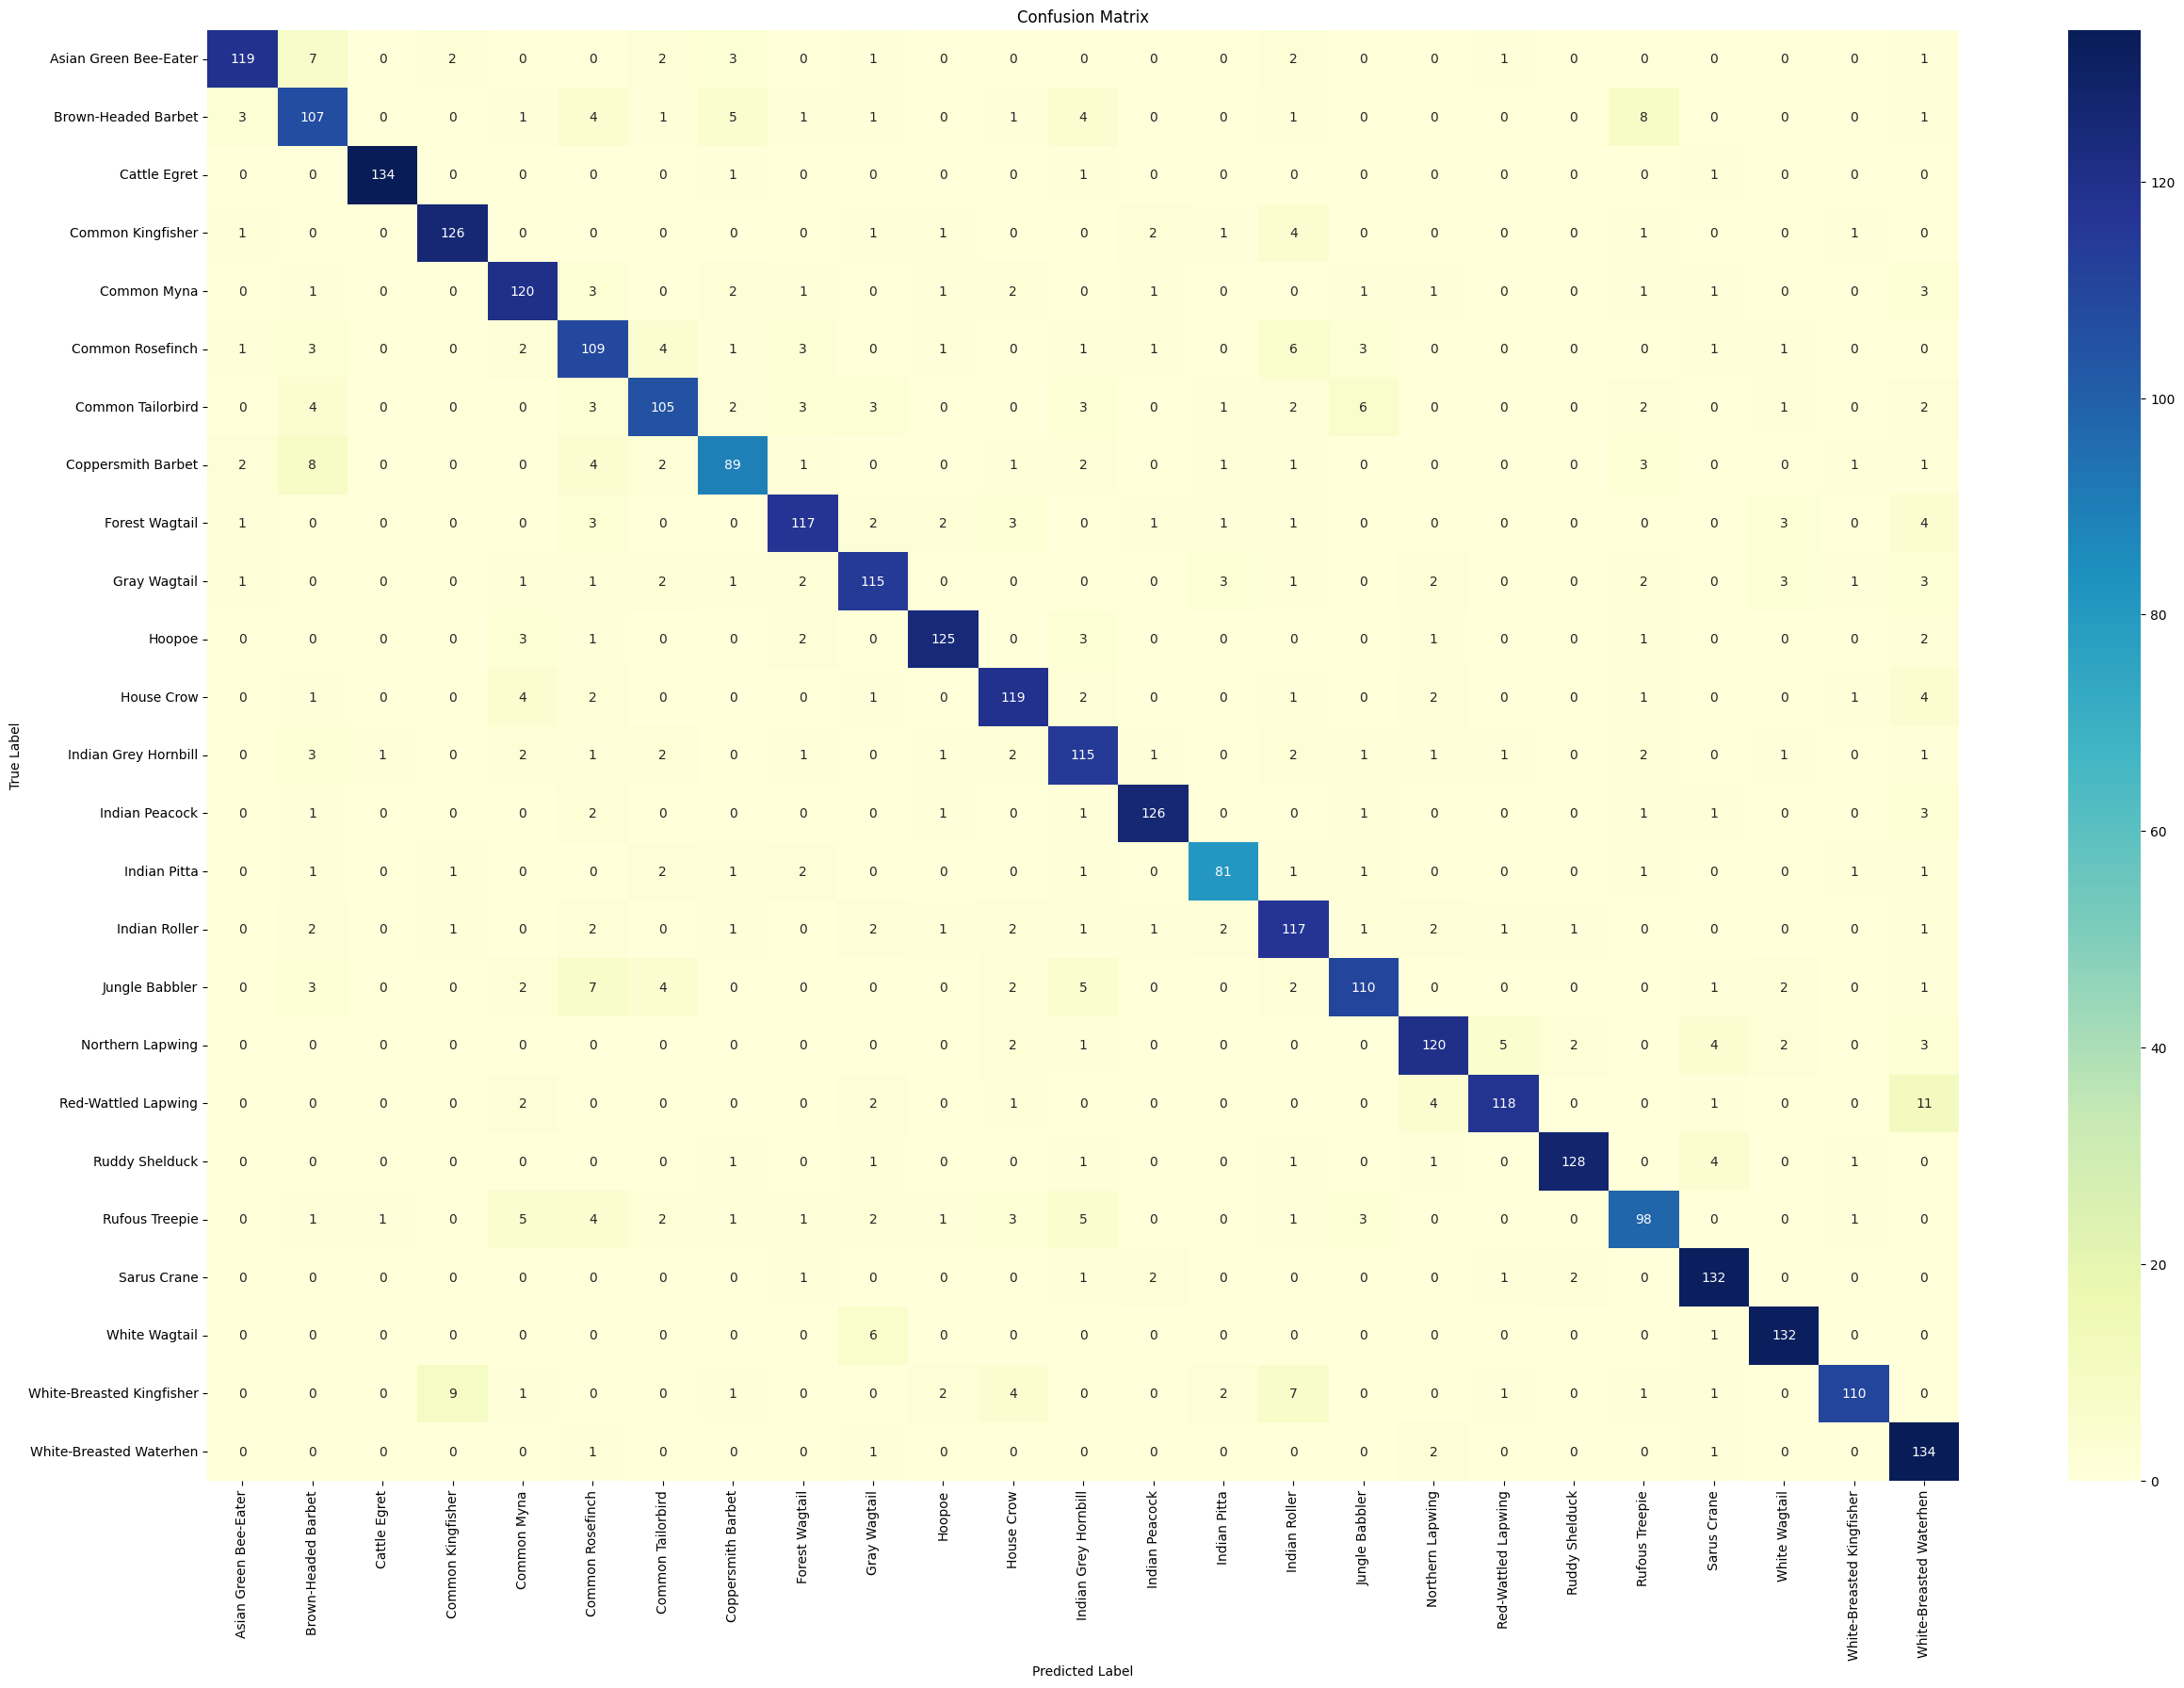

Classification Report:
                           precision    recall  f1-score   support

    Asian Green Bee-Eater       0.93      0.86      0.89       138
      Brown-Headed Barbet       0.75      0.78      0.76       138
             Cattle Egret       0.99      0.98      0.98       137
        Common Kingfisher       0.91      0.91      0.91       138
              Common Myna       0.84      0.87      0.85       138
         Common Rosefinch       0.74      0.80      0.77       137
        Common Tailorbird       0.83      0.77      0.80       137
       Coppersmith Barbet       0.82      0.77      0.79       116
           Forest Wagtail       0.87      0.85      0.86       138
             Gray Wagtail       0.83      0.83      0.83       138
                   Hoopoe       0.92      0.91      0.91       138
               House Crow       0.84      0.86      0.85       138
     Indian Grey Hornbill       0.78      0.83      0.81       138
           Indian Peacock       0.93  

In [28]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(30, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


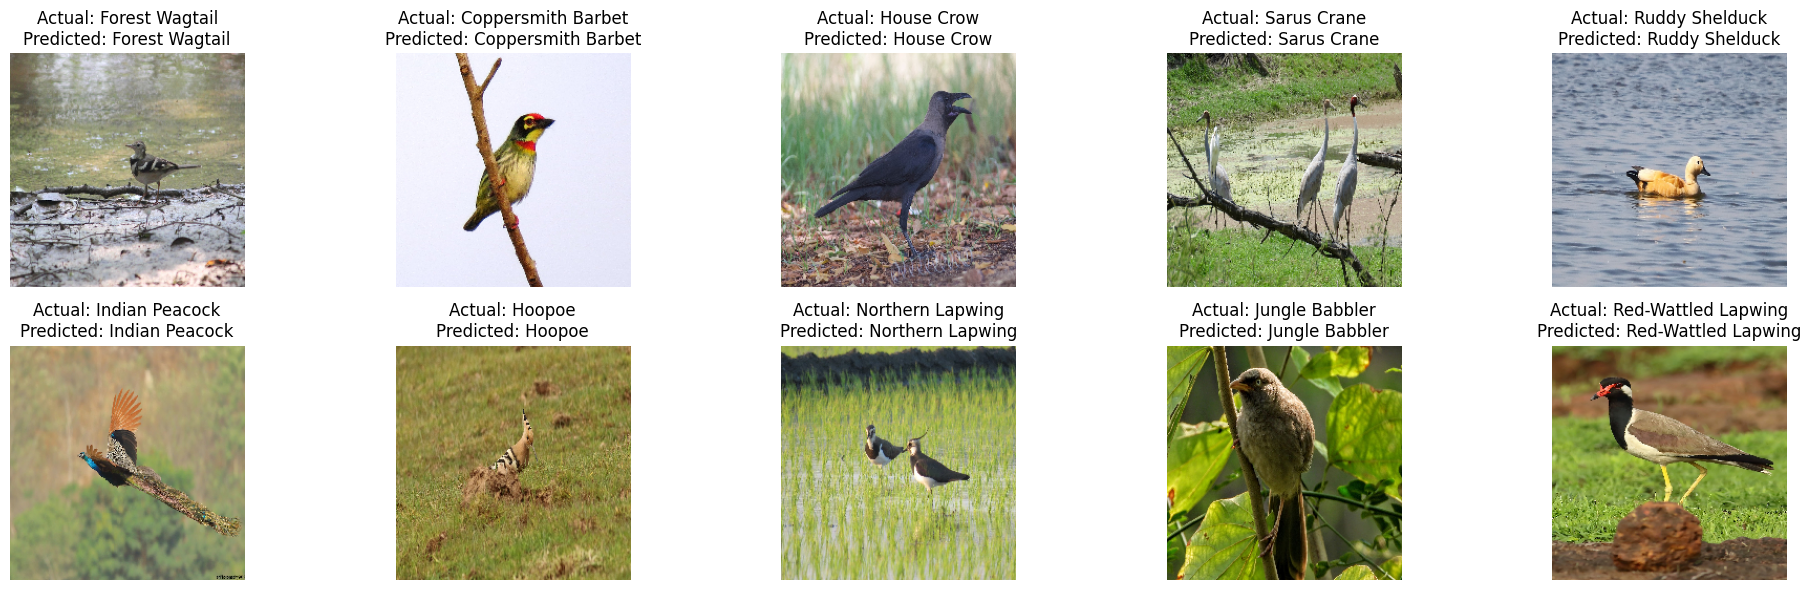

In [25]:
class_names = list(test_generator.class_indices.keys())
num_images = 10

indices = random.sample(range(len(x_test)), num_images)
images = x_test[indices]
true_labels = np.argmax(y_test[indices], axis=1)

images_for_prediction = preprocess_input(images.copy())

predictions = np.argmax(model.predict(images_for_prediction), axis=1)

images_for_display = images / 255.0

plt.figure(figsize=(20, 6))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images_for_display[i])
    plt.title(f"Actual: {class_names[true_labels[i]]}\nPredicted: {class_names[predictions[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()